# Named Entity Recognition using LSTM in Keras
NER is a form of Natural Language Processing technique, where the end result is identifying various entities, like names, places, numbers from the raw text.

## Introduction
Named Entity Recognition can be used as a standalone tool but also as a preprocessing toolfor later applications in *Machine Translation*, *Customer Feedback Hanlding*, and even *Text Summarization*.


## 1. Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


In [2]:
# ! pip install numpy

In [122]:
# ! pip install --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --upgrade livelossplot

## 2. Explore NER Dataset
This dataset contains of course sentences in English but they also have corresponding annotations for each word. The sentence in dataset are encoded in Latin 1.

Essential info about entities:

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

Total Words Count = 1354149

Target Data Column: “tag”

In [4]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(25)

Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O
20  Sentence: 1           from   IN      O
21  Sentence: 1           that   DT      O
22  Sentence: 1        country   NN      O
23  Sentence: 1              .    .      O
24  Sentence: 2       Families  NNS      O

The column of interest is the rightmost one - where we see the tag for each word. Let's check out the number of unique words in the corpus and number of unique tags:

In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Create a list of unique words

In [6]:
words = list(set(data.Word.values))
words.append("ENDPAD") # end of sentence ?
num_words = len(words)

In [79]:
words[0]

'plucked'

Similar process for target variable (tags)

In [7]:
tags = list(set(data.Tag.values))
num_tags = len(tags)

Now, we are gonna modify our dataset so that we can easily split our dataset into our feature matrix and the target vector. So we want to create two pools (containing 3 values) for each sentence so that the 1st value in the two pools is the word and the 2nd value is the POS(Part of Speech) and 3rd is Tag i.e. class name.

## 3. Retrieve Sentences and Corresponding Tags
Let's retreive sentences and their corresponding tags in a nice format in order to have a clear input and a clear output for our Recurrent Neural Network. 

First, we group given data by sentences. Then we apply lambda function that extracts Word, POS, and TAG for each grouped sentence to create a list of tuples with a structure: (Word to POS to TAG).

In [8]:
class SentenceGetter():
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                            s['POS'].values.tolist(),
                                                            s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

Observe that the first sentence countains the exact information we wanted:

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

## 4. Define Mapping Between Words and Numbers; Between Tags and Numbers
To build an RNN we need to represent words and tags as vectors, or at least as numerical representations (values or indecies).


In [80]:
word2idx = {w : i for i, w in enumerate(words)}
tag2idx = {t : i for i, t in enumerate(tags)}

In [81]:
import pandas as pd
pd.DataFrame.from_dict(word2idx, orient = 'index').tail()

0
Socialists  35174
bolstering  35175
One-third   35176
author      35177
ENDPAD      35178

We can retrieve these words using their indices and looking them up in the dictionary and returing the corresponding keys.

## 5. Padding Input Sentences and Creating Train / Test Splits
To build a Recurrent Neural Netowork we need to be able to use equal length sentences (technical necessity of Keras / Tensorflow packages). Thus we are goin to pad our sentences to a prescribed length. So what will this length be? Let us first look at the distribution of sentences' length - look at the histogram.

Total number of sentences = 47959
Mean of the distribution is 21.863987989741236
IQ range (10% to 99%) of the distribution is [12. 43.]


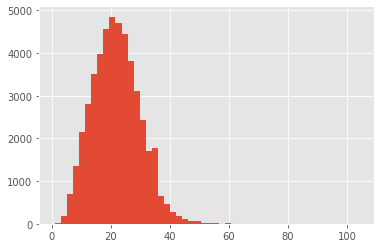

In [82]:
print("Total number of sentences = " + str(len(sentences)))
_ = plt.hist([len(s) for s in sentences], bins = 50)
print("Mean of the distribution is " + str(sum([len(s) for s in sentences])/ len(sentences)))
print("IQ range (10% to 99%) of the distribution is " + str(np.percentile([len(s) for s in sentences], [10, 99])))

Looking at the plot, considering the mean, the IQ ranges we can observe that maxing out at the length 50 should capture a vast moajority of sentences.

### 5.1 Padding
X is going to be a numerical representation of our words for each sentence (we could potentially use a far better word to vector embedding). Iterate over each word to get a corresponding value for that word.

To pad we will use pad_sequence function from the Tensorflow package, where we will specify the maxlen parameter to indicate maximum length each sentences will have and a value parameter - what we are padding with. 

In [83]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value=tag2idx['O'])

Let's split the dataset into training and testing to test our final model's performance. Let's set the test size at 20%.

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, _train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## 6. Bidirectional LSTM Model

In this section we are going to build an architecture for the predictive model. Some of the questions pertaining to the model's architecture:

**Why use Bidirectional model?**
- Bidirectional model allows us to make use not only of the past information but also of the future information. Meaning, if we are at node 5 (word 5), we not only use information about previous 4 words, but also take into account what relationships are present in words 6 - 50.

**Why use LSTM and not just simple RNN?**
- Regular RNN has a few major drawbacks: vanishing moments, and they are heavily influenced by close dependencies. LSTM addresses both problems by indroducing a "memory cell", which better stores information from the past and at each next node, LSTM considers whether to use more current information or weigh in more towards the past.
- unites are ~ channels (think of various interpretations / features of that particular spot in a sequence)
- so LSTM can either return (N observations, time-steps, features / channels)
- return_sequences = True (many-to-many) has the effect of each LSTM unit returning a sequence of y_lenth outputs (aka time-steps != 1), one for each time step in the input data, instead of single output value if return_sequences = False (many-to-one).

helpful links: (https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563, https://datascience.stackexchange.com/questions/10836/the-difference-between-dense-and-timedistributeddense-of-keras, ind helpful: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)

**Why use Embedding layer?**
- In the Embedding layer words are represented by dense vectors where a vector represents the projection of the word (input vector space) into a continuous vector space (output vector space).

**Why use TimeDistributed layer?**
- Applies something (we specify this to be a dense layer) to each time step vector individually. Distribute dense layer calculation across time! If we get 700 (h_1, h_2, ... h_700) LSTM vectors (1 - observation, time-step, 200 - channels) - with the dense layer we collapse it to (1, 1) - for the first observation at time-step 1

**What is and why use SpatialDropout?**
- Drops entire 1D feature maps instead of individual elements (used in convolution). So after embedding we have each word represented by a 1x50 vector. SpatialDropout will then take 10% of those channels and zero them out across ALL words. This is done to avoid co-adaptpation - forming a dependency group from one channel to another - a regularization method
https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it

In [85]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Let us first define an input shape. In keras we use Input to tell our model what object size is going through its pipeline. In this case, we are going to have an object of shape max length of a sentence, currently set to 50. Comma is there to indicate that it is not an integer, but a shape of an array.

Then we go on to the Embedding layer. This layer creates dense layers from sparse word vectors using word2vec or GloVe algorithms / methodologies. We can again think of this as creating new channels to represent word (not necessaryly, but each channel can tell us the word's plurality or singularity, masculine or feminine, has some connotation estimation as so on).

In order to avoid overfitting by creating dependencies between those channels (let's say the model has picked up that combining channel 30 with channel 47 produces lower loss), we break those dependencies by introducing a SpatialDropout layer, which nulls out the entire channel.

Next, we go on to creating Bidirection LSTM layer - LSTM's units - in the output # of channels - I think of it as different insights LSTM got from analyzing data, sort of like new features or hidden units in a regular NN. We must declare return_sequences = True, as we are interested in obtaining output vectors for every time step (many-to-many).

Finally, we need to convert Bidirectional LSTM's channels into tags, thus we need to apply a simple Dense layer to EACH time step. That is why we use Time-distributed layer. It applies Dense layer (with the same weights) to ALL time steps to produce a singular output - Tag with the highest probability after softmax.

In [102]:
input_word = Input(shape=(max_len,)) # batch of max_len dimensional vectors

# model
model = Embedding(input_dim = num_words, output_dim = 50, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model) # drops entire 1D feature maps instead of individual elements
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model) # units - dimensions of the output 1 word (after embedding 1 x 250) becomes (1 x 100) after LSTM
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model) # probability of each word being eah tag
model = Model(input_word, out)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


The model produces a total of 1,883,167 parameters. How exactly are they calculated? Let's find out:

In [116]:
# lstm has a set of 3 gates: forget, update, and output, and a separate weight to calculate the cell state c. For each 
# gate and cell state calculation we have a set of 2 matricies: matrix that deals with a hidden unit at time step t-1 and matrix that
# deals with an input x_t. So we have 4 sets of parameters and each has 2 matricies:
lstm_num_params = 4 * (100 * 50 + 100 * 100 + 100)
print('Number of LSTM parameters: ', lstm_num_params)

# Now deal with the bidirectional part. We are going to end up having 2 hidden unit from 2 directions: forward and backward. 
print('Number of Bidirection LSTM parameters: ', 2 * lstm_num_params)

#  time distributed / dense layer: output_size * (input_size + 1) - because of the bias + 1
dense_num_params = 2 * 17 * (100) + 17 # maybe same bias unit is applied to both forward and backward
print('Number of Time-Distributed Dense parameters: ', dense_num_params)

Number of LSTM parameters:  60400
Number of Bidirection LSTM parameters:  120800
Number of Time-Distributed Dense parameters:  3417


Next, let's compile a model. We are using the most popular optimizer algorithm - Adam, out loss function is sparse categorical cross entropy (classes are mutually exclusive), and out metric is accuracy

In [117]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=["accuracy"]) # what is sparse_categorical_crossentropy

Time to train and test our model. By importing ModelCheckpoint we can save the best model, monitor our calidation loss. Early Stopping allows us to early stop when we do not continue to improve on our model after 2 batches. Finally, PlotLossesCallback is a wayt to visualize our loss.

In [118]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.inputs.tf_keras import PlotLossesCallback

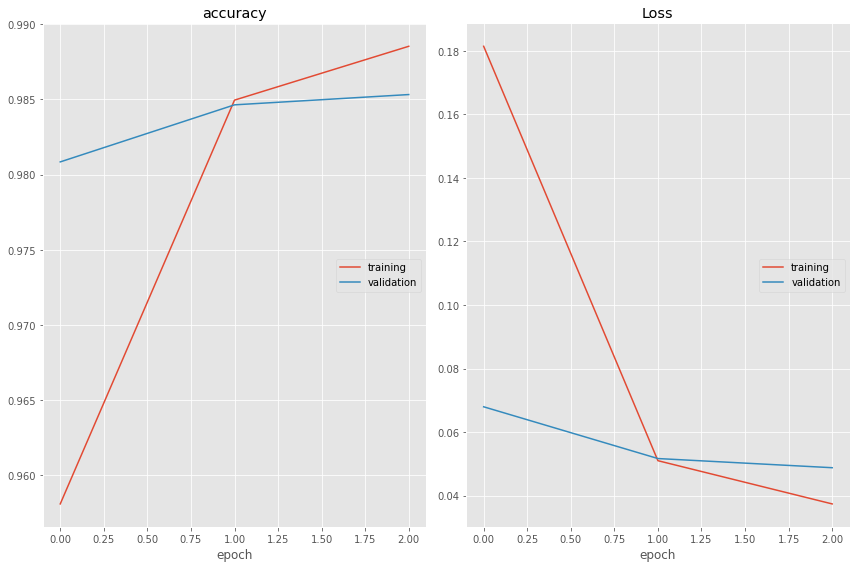

accuracy
	training         	 (min:    0.958, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.037, max:    0.181, cur:    0.037)
	validation       	 (min:    0.049, max:    0.068, cur:    0.049)

Epoch 00003: val_loss improved from 0.05168 to 0.04879, saving model to model_weights.h5
1199/1199 [==============================] - 133s 111ms/step - loss: 0.0374 - accuracy: 0.9885 - val_loss: 0.0488 - val_accuracy: 0.9853


In [119]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)
my_callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32, 
    epochs=3,
    verbose=1,
    callbacks = my_callbacks
)

In [120]:
model.evaluate(X_test, y_test)

300/300 [==============================] - 4s 14ms/step - loss: 0.0488 - accuracy: 0.9853


[0.04879415035247803, 0.9853190183639526]

In [121]:
i = np.random.randint(0, X_test.shape[0]) # 659
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
She            O	O
remains        O	O
hospitalized   O	O
.              O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD    